# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Read-Pretrained-Model" data-toc-modified-id="Read-Pretrained-Model-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Read Pretrained Model</a></div><div class="lev2 toc-item"><a href="#Use-Word2vec-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Word2vec-to-Initialize-Embedding-Matrix-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use Word2vec to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Load--Autoencoder" data-toc-modified-id="Load--Autoencoder-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load  Autoencoder</a></div><div class="lev1 toc-item"><a href="#K-means-clustering" data-toc-modified-id="K-means-clustering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>K-means clustering</a></div><div class="lev2 toc-item"><a href="#ALL" data-toc-modified-id="ALL-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>ALL</a></div><div class="lev2 toc-item"><a href="#Causal" data-toc-modified-id="Causal-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Causal</a></div><div class="lev1 toc-item"><a href="#LDA" data-toc-modified-id="LDA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>LDA</a></div>

# Load Data

In [252]:
import json
import os

In [253]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [254]:
sentence = load_data('all_data.json', 'sentence')
label = load_data('all_data.json', 'label')

# Word Segmentation

In [255]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [256]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')

In [257]:
filename = "stopwords.txt"
stopWords = [w for w in open(filename).read().split()]

In [258]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [259]:
casualSent = [sentence[i] for i in range(len(sentence)) if label[i] == 1]
c_sentWords = [del_stop(newcut(s)) for s in casualSent]
sentWords = [del_stop(newcut(s)) for s in sentence]

# Tokenize Text

In [260]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [288]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentSeq = tokenizer.texts_to_sequences(tokTexts)
x = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
cauTexts = [' '.join(i) for i in c_sentWords]
cauSeq = tokenizer.texts_to_sequences(cauTexts)
cx = pad_sequences(cauSeq, maxlen=MAX_LEN, padding='post', truncating='post')
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	20332
Distribution of sentence lengths (number of words):
Min: 12   Max: 472   Mean: 69.997   Med: 67.000
Found 55935 unique tokens.


In [265]:
MAX_LEN = 150 # Approximately twice the median length of sentences

# Word Embedding

In [266]:
VOCAB_SIZE = len(index2word)+1
EMBEDDING_SIZE = 256
SEED = 42

## Read Pretrained Model

In [40]:
import gensim

In [41]:
word2vec = gensim.models.Word2Vec.load('/Users/lizhn7/Downloads/DATA/word2vec/word2vec_wx')
word2vec.init_sims(replace=True)
w2v_embedding_weights = word2vec.wv.syn0
w2v_embedding_weights.std()

0.062499415

## Use Word2vec to Initialize Embedding Matrix

In [42]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = w2v_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [43]:
count = 0
w2v_dict = word2vec.wv.index2word
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    if w in w2v_dict:
        g = word2vec[w]
        embedding[i, :] = g
        count += 1
print('{num_tokens}-{per:.3f}% tokens in vocab found in word2vec and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

37268-66.626% tokens in vocab found in word2vec and copied to embedding.


# Load  Autoencoder

In [44]:
MAX_LEN = 150
VOCAB_SIZE = 55936
EMBEDDING_SIZE = 256
LATENT_SIZE = 512
NUM_EPOCHS = 36
BATCH_SIZE = 64

In [45]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [46]:
K.clear_session()
inputs = Input(shape=(MAX_LEN,), name='INPUT') 
emb = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, weights=[embedding], mask_zero=True, input_length=MAX_LEN, trainable=False, name='EMBEDDING')(inputs)
encoded = Bidirectional(LSTM(LATENT_SIZE, return_sequences=False, implementation=0), merge_mode='sum', name='ENCODER_BiLSTM')(emb)
decoded = RepeatVector(MAX_LEN, name="REPEATER")(encoded)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, implementation=0), merge_mode='sum', name='DECODER_BiLSTM')(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(loss='mse', optimizer='rmsprop')

In [268]:
filename = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/cp_logs/weights.029-0.001561.hdf5'
autoencoder.load_weights(filename)

In [269]:
# extract encoder part from autoencoder
encoder = Model(autoencoder.input, autoencoder.get_layer("ENCODER_BiLSTM").output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 150)               0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 150, 256)          14319616  
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
Total params: 17,469,440
Trainable params: 3,149,824
Non-trainable params: 14,319,616
_________________________________________________________________


In [271]:
sent2vec = encoder.predict(x, batch_size=BATCH_SIZE, verbose=1)

20332/20332 [==============================] - 1469s  


In [311]:
c_sent2vec = encoder.predict(cx, batch_size=BATCH_SIZE, verbose=1)

824/824 [==============================] - 66s    


# K-means clustering

In [277]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [297]:
stopList = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2000', '2014', '20142016', '2015', '2016', '2017', '2018', '2019', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '300', '3000', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '500', '5000', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '150', '4000']

In [319]:
def train(X, document, num_clusters=10, showLable=False, n_features=512):
    """
    K-means training
    """
    km = KMeans(n_clusters=num_clusters, 
                init='k-means++', 
                max_iter=300, 
                n_init=1,
                verbose=False)
    km.fit(X)    
    if showLable:
        print("Top terms per cluster:")
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]
        vectorizer = TfidfVectorizer(max_df=0.5, 
                                     max_features=n_features, 
                                     stop_words=stopList,
                                     min_df=2,
                                     use_idf=True)
        x = vectorizer.fit_transform(document)
        terms = vectorizer.get_feature_names()
        print(vectorizer.get_stop_words())
        for i in range(num_clusters):
            print("Cluster %d:" % i, end='')
            for ind in order_centroids[i, :11]:
                print(' %s' % terms[ind], end='')
            print()
    result = km.labels_.tolist()
    print ('Cluster distribution:')
    print (dict([(i, result.count(i)) for i in result]))
    return (-km.score(X), result)

def test(feature, document):
    """
    Select optimal parameter
    """
    print("%d Sentence" % len(feature))
    true_ks = []
    scores = []
    for i in tqdm(range(1,20,1)):        
        score = train(feature, document, num_clusters=i)[0] * len(feature)
        print(i, score)
        true_ks.append(i)
        scores.append(score)
    plt.figure(figsize=(8,4))
    plt.plot(true_ks, scores,label="loss", color="red", linewidth=1)
    plt.xlabel("num_clusters")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

## ALL 

  0%|          | 0/19 [00:00<?, ?it/s]

20332 Causal Sentence
Cluster distribution:


  5%|▌         | 1/19 [00:02<00:51,  2.87s/it]

{0: 20332}
1 0.280217003832
Cluster distribution:


 11%|█         | 2/19 [00:15<01:37,  5.74s/it]

{0: 11117, 1: 9215}
2 0.137470246255
Cluster distribution:
{1: 7768, 0: 5977, 2: 6587}


 16%|█▌        | 3/19 [00:32<02:24,  9.05s/it]

3 0.104652664481
Cluster distribution:


 21%|██        | 4/19 [00:49<02:51, 11.46s/it]

{3: 6523, 2: 2186, 0: 6031, 1: 5592}
4 0.0892081844356
Cluster distribution:


 26%|██▋       | 5/19 [01:04<02:58, 12.74s/it]

{0: 5569, 4: 1720, 3: 3142, 1: 5041, 2: 4860}
5 0.0785294741399
Cluster distribution:


 32%|███▏      | 6/19 [01:22<03:02, 14.06s/it]

{0: 5428, 1: 2540, 4: 3000, 5: 4310, 2: 4516, 3: 538}
6 0.07273651904
Cluster distribution:


 37%|███▋      | 7/19 [01:41<03:08, 15.67s/it]

{5: 4296, 6: 2272, 3: 2275, 1: 3434, 4: 3879, 0: 3671, 2: 505}
7 0.0690365046546
Cluster distribution:


 42%|████▏     | 8/19 [02:02<03:09, 17.24s/it]

{7: 1646, 2: 2089, 6: 2459, 3: 3603, 0: 3179, 4: 3226, 1: 3668, 5: 462}
8 0.0664997612253
Cluster distribution:


 47%|████▋     | 9/19 [02:23<03:02, 18.27s/it]

{6: 1469, 2: 1600, 5: 1944, 3: 2744, 1: 2754, 0: 3227, 8: 2931, 4: 3269, 7: 394}
9 0.0642006390666
Cluster distribution:


 53%|█████▎    | 10/19 [02:41<02:46, 18.45s/it]

{1: 1461, 4: 1395, 8: 1940, 6: 2726, 3: 2462, 7: 3195, 2: 2454, 0: 3163, 9: 1187, 5: 349}
10 0.0619903880905
Cluster distribution:
{9: 1301, 4: 1462, 8: 1438, 3: 1496, 10: 2207, 2: 2649, 7: 2818, 0: 2977, 1: 1197, 6: 2416, 5: 371}


 58%|█████▊    | 11/19 [03:06<02:43, 20.42s/it]

11 0.0600851691703
Cluster distribution:


 63%|██████▎   | 12/19 [03:26<02:21, 20.24s/it]

{1: 1298, 11: 1073, 7: 1400, 10: 1454, 5: 2163, 0: 2474, 2: 2574, 4: 2578, 6: 1625, 8: 1132, 9: 2262, 3: 299}
12 0.0584415967484
Cluster distribution:


 68%|██████▊   | 13/19 [03:47<02:01, 20.30s/it]

{9: 1277, 10: 965, 11: 1386, 2: 1577, 3: 1491, 12: 2136, 5: 2528, 8: 1031, 4: 2216, 7: 1099, 0: 2220, 1: 2140, 6: 266}
13 0.056717784555
Cluster distribution:
{5: 1261, 13: 989, 4: 1285, 2: 1535, 6: 1368, 10: 2114, 11: 1996, 3: 979, 0: 2188, 9: 1111, 12: 1759, 1: 2096, 8: 1382, 7: 269}


 74%|███████▎  | 14/19 [04:10<01:46, 21.25s/it]

14 0.0554021381697
Cluster distribution:
{8: 1236, 5: 1059, 2: 1220, 6: 1458, 11: 1701, 10: 1922, 4: 1760, 3: 1626, 13: 935, 7: 1576, 1: 1123, 0: 1753, 14: 1229, 12: 1438, 9: 296}


 79%|███████▉  | 15/19 [04:30<01:23, 20.77s/it]

15 0.0541418760137
Cluster distribution:


 84%|████████▍ | 16/19 [04:48<01:00, 20.05s/it]

{8: 1221, 7: 1039, 14: 1210, 2: 1149, 12: 1330, 0: 1871, 11: 1396, 4: 1421, 5: 940, 9: 1565, 10: 1543, 6: 1099, 15: 1631, 13: 1362, 1: 1262, 3: 293}
16 0.0533393823965
Cluster distribution:


 89%|████████▉ | 17/19 [05:10<00:41, 20.61s/it]

{4: 1210, 11: 1268, 5: 1167, 9: 1355, 15: 1756, 10: 657, 12: 1602, 14: 1634, 3: 1336, 7: 887, 8: 1524, 16: 1556, 2: 568, 1: 1189, 0: 1437, 13: 965, 6: 221}
17 0.0518314861087
Cluster distribution:
{5: 1193, 0: 1084, 8: 1151, 1: 1325, 16: 1728, 4: 642, 7: 1387, 9: 1590, 15: 1201, 10: 867, 6: 1371, 12: 1258, 2: 1561, 14: 496, 11: 1170, 3: 1161, 17: 935, 13: 212}


 95%|█████████▍| 18/19 [05:32<00:21, 21.04s/it]

18 0.0509561408716
Cluster distribution:


100%|██████████| 19/19 [05:56<00:00, 21.75s/it]

{16: 1164, 7: 1086, 11: 941, 4: 1330, 8: 1427, 13: 641, 1: 1359, 2: 1500, 5: 1107, 6: 837, 0: 1179, 18: 1364, 12: 1616, 3: 492, 15: 1093, 10: 1016, 9: 927, 17: 1041, 14: 212}
19 0.0501510841686


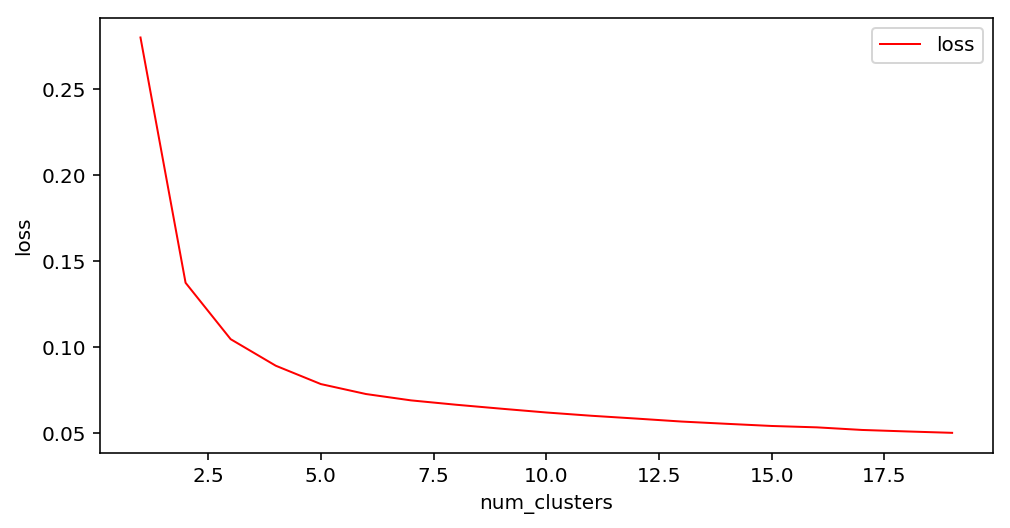

In [302]:
test(sent2vec, tokTexts)

In [307]:
result = train(sent2vec, tokTexts, num_clusters=3, showLable=True)

Top terms per cluster:
frozenset({'34', '03', '39', '32', '75', '86', '59', '37', '85', '200', '150', '68', '52', '83', '06', '13', '42', '500', '00', '46', '28', '74', '27', '30', '58', '98', '09', '02', '73', '84', '87', '56', '70', '69', '2000', '77', '100', '45', '62', '33', '54', '71', '16', '47', '99', '01', '53', '65', '88', '48', '44', '57', '50', '90', '2017', '07', '67', '76', '41', '05', '40', '96', '35', '23', '94', '81', '04', '300', '2016', '5000', '93', '80', '29', '11', '55', '3000', '66', '31', '14', '19', '20', '38', '21', '2018', '15', '49', '10', '72', '4000', '95', '79', '60', '82', '26', '20142016', '08', '24', '89', '2015', '92', '78', '25', '2014', '51', '63', '64', '1000', '91', '36', '61', '97', '18', '22', '12', '43', '2019', '17'})
Cluster 0: 财务 规定 材料 每股 近日 浙江 资金 江苏 收益 新能源 提供
Cluster 1: 成员 规定 据悉 位数 提供 股本 财务 承诺 材料 收到 收益
Cluster 2: 规定 财务 材料 资金 收益 提供 浙江 成员 新能源 万股 构成
Cluster distribution:
{1: 7768, 0: 5977, 2: 6587}


In [308]:
result = [result[1][i] for i in range(len(result[1])) if label[i] == 1]
print ('Casual Cluster distribution:')
print (dict([(i, result.count(i)) for i in result]))

Casual Cluster distribution:
{1: 394, 0: 155, 2: 275}


## Causal

 11%|█         | 2/19 [00:00<00:01, 11.39it/s]

824 Sentence
Cluster distribution:
{0: 824}
1 158103.013047
Cluster distribution:
{1: 506, 0: 318}
2 79343.7826227


 16%|█▌        | 3/19 [00:00<00:01,  8.87it/s]

Cluster distribution:
{2: 311, 0: 292, 1: 221}
3 58793.7130179


 21%|██        | 4/19 [00:00<00:02,  5.97it/s]

Cluster distribution:
{0: 293, 2: 263, 1: 101, 3: 167}
4 52734.1797009


 26%|██▋       | 5/19 [00:00<00:03,  4.60it/s]

Cluster distribution:
{3: 119, 4: 179, 1: 196, 0: 148, 2: 182}
5 47545.0670887


 32%|███▏      | 6/19 [00:01<00:03,  3.94it/s]

Cluster distribution:
{1: 109, 4: 174, 0: 81, 3: 132, 2: 181, 5: 147}
6 43158.6953525


 37%|███▋      | 7/19 [00:01<00:03,  3.60it/s]

Cluster distribution:
{6: 111, 0: 145, 4: 137, 1: 81, 3: 104, 5: 99, 2: 147}
7 40991.750639


 53%|█████▎    | 10/19 [00:01<00:01,  5.01it/s]

Cluster distribution:
{3: 103, 1: 166, 2: 71, 0: 80, 7: 132, 4: 117, 5: 65, 6: 90}
8 39276.2665764
Cluster distribution:
{4: 102, 5: 122, 8: 125, 7: 66, 0: 100, 6: 99, 1: 73, 3: 106, 2: 31}
9 37582.0453521
Cluster distribution:
{6: 94, 3: 106, 5: 123, 9: 79, 7: 70, 0: 85, 4: 78, 2: 58, 1: 100, 8: 31}
10 36678.5619685


 58%|█████▊    | 11/19 [00:02<00:01,  5.48it/s]

Cluster distribution:
{5: 88, 0: 44, 8: 112, 7: 96, 2: 60, 10: 78, 3: 83, 4: 92, 6: 60, 1: 100, 9: 11}
11 34827.045411


 63%|██████▎   | 12/19 [00:02<00:01,  4.39it/s]

Cluster distribution:
{2: 87, 1: 61, 5: 100, 7: 88, 4: 67, 9: 63, 8: 52, 11: 85, 0: 50, 6: 86, 10: 29, 3: 56}
12 33795.5879126
Cluster distribution:


 74%|███████▎  | 14/19 [00:02<00:00,  5.39it/s]

{9: 85, 3: 73, 2: 74, 0: 61, 4: 69, 5: 80, 6: 81, 12: 54, 1: 57, 10: 11, 11: 97, 7: 36, 8: 46}
13 34029.2191041
Cluster distribution:
{3: 90, 10: 49, 1: 77, 11: 56, 0: 65, 8: 51, 6: 76, 9: 81, 12: 52, 5: 72, 13: 6, 4: 75, 2: 39, 7: 35}
14 32505.543154


 79%|███████▉  | 15/19 [00:02<00:00,  5.23it/s]

Cluster distribution:
{11: 57, 0: 51, 6: 84, 8: 71, 3: 66, 7: 44, 2: 54, 9: 53, 10: 46, 1: 83, 12: 30, 5: 48, 4: 59, 13: 55, 14: 23}
15 31696.758229


 89%|████████▉ | 17/19 [00:03<00:00,  6.03it/s]

Cluster distribution:
{12: 69, 14: 36, 4: 58, 7: 69, 15: 69, 6: 46, 5: 42, 9: 47, 8: 46, 1: 61, 0: 46, 10: 36, 2: 57, 11: 64, 3: 50, 13: 28}
16 31043.8146105
Cluster distribution:
{16: 54, 0: 42, 14: 40, 11: 44, 13: 36, 5: 62, 10: 45, 3: 51, 1: 55, 4: 51, 15: 58, 6: 85, 12: 19, 8: 51, 9: 42, 7: 49, 2: 40}
17 30498.2956712


 95%|█████████▍| 18/19 [00:03<00:00,  4.94it/s]

Cluster distribution:
{5: 59, 1: 40, 9: 76, 12: 27, 3: 56, 17: 30, 13: 68, 16: 22, 15: 61, 7: 40, 0: 32, 8: 62, 10: 19, 2: 63, 11: 24, 14: 36, 6: 43, 4: 66}
18 29800.2187883


100%|██████████| 19/19 [00:04<00:00,  3.35it/s]

Cluster distribution:
{5: 68, 10: 36, 4: 47, 8: 73, 18: 33, 12: 39, 3: 50, 16: 35, 9: 38, 11: 68, 7: 41, 13: 55, 17: 5, 2: 58, 15: 8, 14: 53, 0: 48, 1: 34, 6: 35}
19 29219.6036264


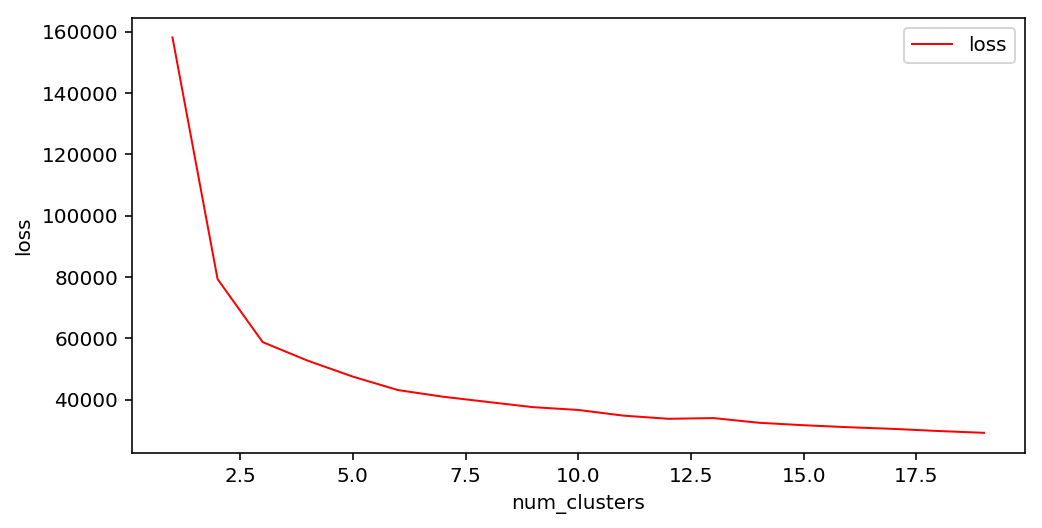

In [320]:
test(c_sent2vec, cauTexts)

In [326]:
result = train(c_sent2vec, cauTexts, num_clusters=3, showLable=True)
result[0]

Top terms per cluster:
frozenset({'34', '03', '39', '32', '75', '86', '59', '37', '85', '200', '150', '68', '52', '83', '06', '13', '42', '500', '00', '46', '28', '74', '27', '30', '58', '98', '09', '02', '73', '84', '87', '56', '70', '69', '2000', '77', '100', '45', '62', '33', '54', '71', '16', '47', '99', '01', '53', '65', '88', '48', '44', '57', '50', '90', '2017', '07', '67', '76', '41', '05', '40', '96', '35', '23', '94', '81', '04', '300', '2016', '5000', '93', '80', '29', '11', '55', '3000', '66', '31', '14', '19', '20', '38', '21', '2018', '15', '49', '10', '72', '4000', '95', '79', '60', '82', '26', '20142016', '08', '24', '89', '2015', '92', '78', '25', '2014', '51', '63', '64', '1000', '91', '36', '61', '97', '18', '22', '12', '43', '2019', '17'})
Cluster 0: 要约 调查 成员 标的 提供 深交所 资产重组 使用 改革 款项 上海
Cluster 1: 损失 成员 使用 承接 要约 提供 收益 标的 深交所 面临 上半年
Cluster 2: 调查 要约 标的 法院 深交所 提供 方式 改革 运营 资产重组 派息
Cluster distribution:
{0: 311, 1: 292, 2: 221}


71.351593468338251

# LDA